In [275]:
import platform
from pathlib import Path
from datetime import datetime, timedelta
import datajoint as dj
dj.blob.use_32bit_dims = True # necessary for pd.blob read

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from multiplot_summaries import *

import plot_utils as pu
import dj_utils as dju
import dir_utils as du

from plot_trials_info import *
from plot_days_info import *

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# PATHS
if platform.system() == "Windows":
    FIGURES_PATH = Path(
        "C:\\Users\\JB\\github\\jbreda_animal_training\\figures\\mice\\cohort3"
    )
    DATA_PATH = Path("C:\\Users\\JB\\github\\jbreda_animal_training\\data\\days_dfs")
else:
    FIGURES_PATH = Path(
        "/Users/jessbreda/Desktop/github/jbreda_animal_training/figures/mice/cohort3"
    )
    DATA_PATH = Path(
        "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/days_dfs"
    )

# ANIMALS
ANIMAL_IDS = ["R013", "R014", "R015"]

# DATES
# date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=20)
date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=2)
# few_days_ago = (datetime.today() - timedelta(days=4)).strftime("%Y-%m-%d")
today = datetime.today().date()

# LOAD IN TRIALS DATA
# trials_df = create_trials_df_from_dj(
#     animal_ids=ANIMAL_IDS, date_min="2023-11-21", date_max="2023-11-12"
# )
days_trials_df = create_trials_df_from_dj(
    animal_ids=ANIMAL_IDS, date_min=date_min, date_max=date_max
)

fetched 3 sessions for R013 between 2023-11-19 and 2023-11-21
fetched 3 sessions for R014 between 2023-11-19 and 2023-11-21
fetched 3 sessions for R015 between 2023-11-19 and 2023-11-21


In [238]:
days_trials_df = pd.read_csv(
    "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/offline/pro_anti_plots.csv"
)

days_trials_df.block_switch_type = days_trials_df.block_switch_type.replace(
    {"['s']": "static"}
)


# "C:\\Users\\JB\\github\\jbreda_animal_training\\data\\offline\\pro_anti_plots.csv")

## Plot to make
[x] plot_block_size_days include std to determine the set block size parameter

-  might be worth splitting the multi plot into multiple functions because adding three plots to bottom mixes up the dates quite a bit

[x] plot_block_switch_type very similar to the give plot where its just a dot for the options over days don't care about color

[x] plot_block_switch_thresholds
    - if less than 15, plot viol & hit thresh rates, otherwise skip this plot and do pro probs instead

[x] plot pro probs
    - if at stage 15 plot pro probs over days

[x] add max block to n_blocks if in stage 15

In [259]:
trials_df = days_trials_df.query("animal_id == 'R013'").copy()

In [318]:
def plot_pro_prob(trials_df, ax=None, title="", xaxis_label=False):
    """
    plot the probability of pro trials over days
    NOTE this is only for stages where blocks turn
    off and pro/anti trials are sampled from a
    normal distribution parameterized by pro rate

    params
    ------

    """
    if ax is None:
        _, ax = pu.make_fig()

    sns.lineplot(data=trials_df, x="date", y="pro_prob", color="pink", marker="o")

    # aethetics
    pu.set_date_x_ticks(ax, xaxis_label)
    ax.grid()
    ax.set(ylabel="Pro Probability", xlabel="", title=title, ylim=(0, 1))

    return None

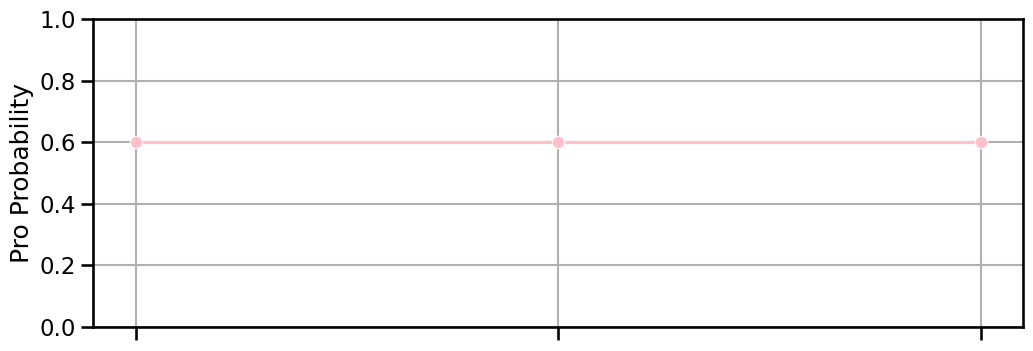

In [319]:
plot_pro_prob(trials_df)

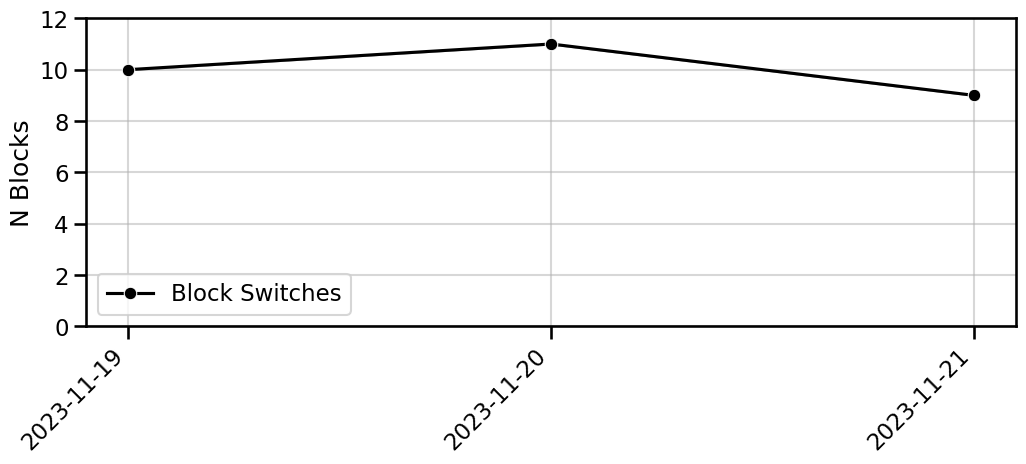

In [286]:
plot_n_pro_anti_blocks_days(trials_df)

In [270]:
trials_df.stage.unique()

array([14.])

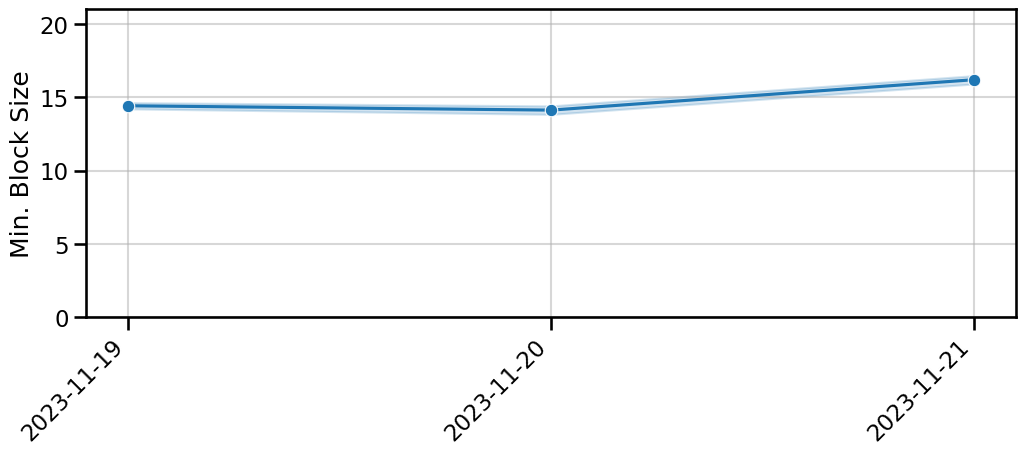

In [266]:
plot_min_block_size(trials_df)

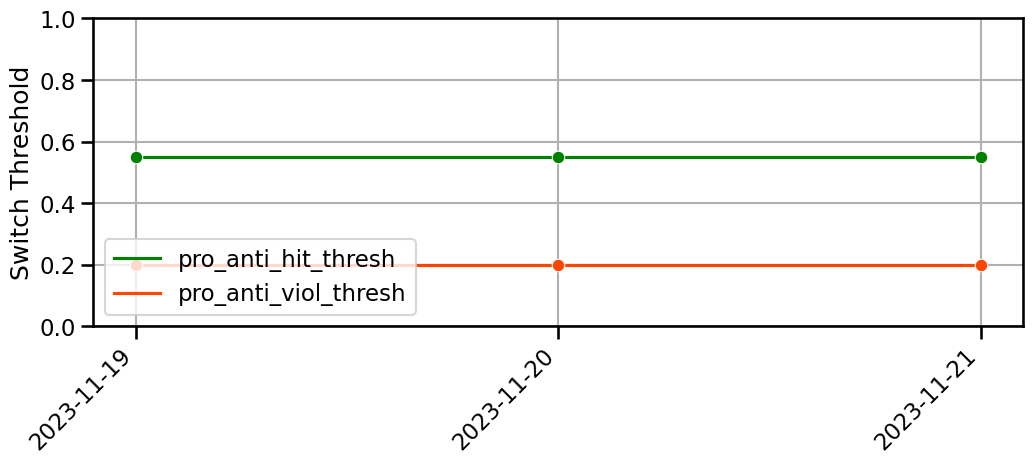

In [253]:
plot_block_switch_thresholds(trials_df)

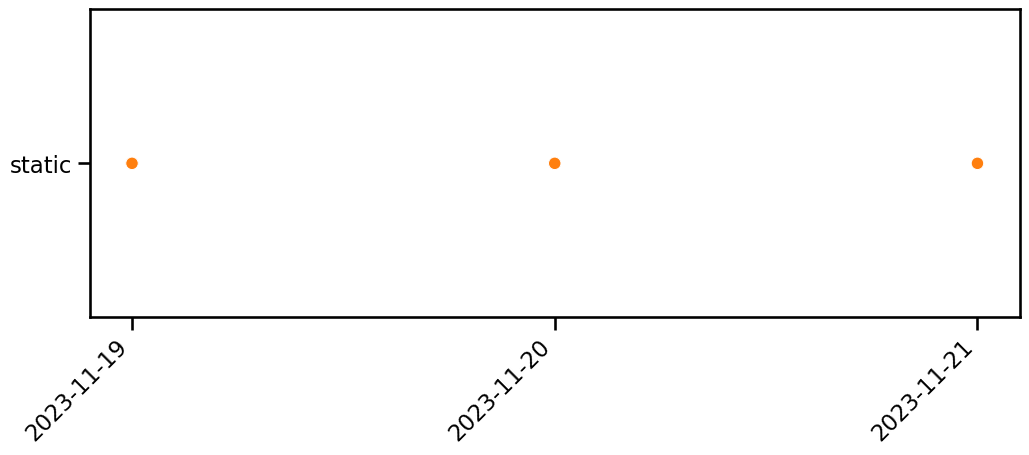

In [255]:
plot_block_switch_days(trials_df)

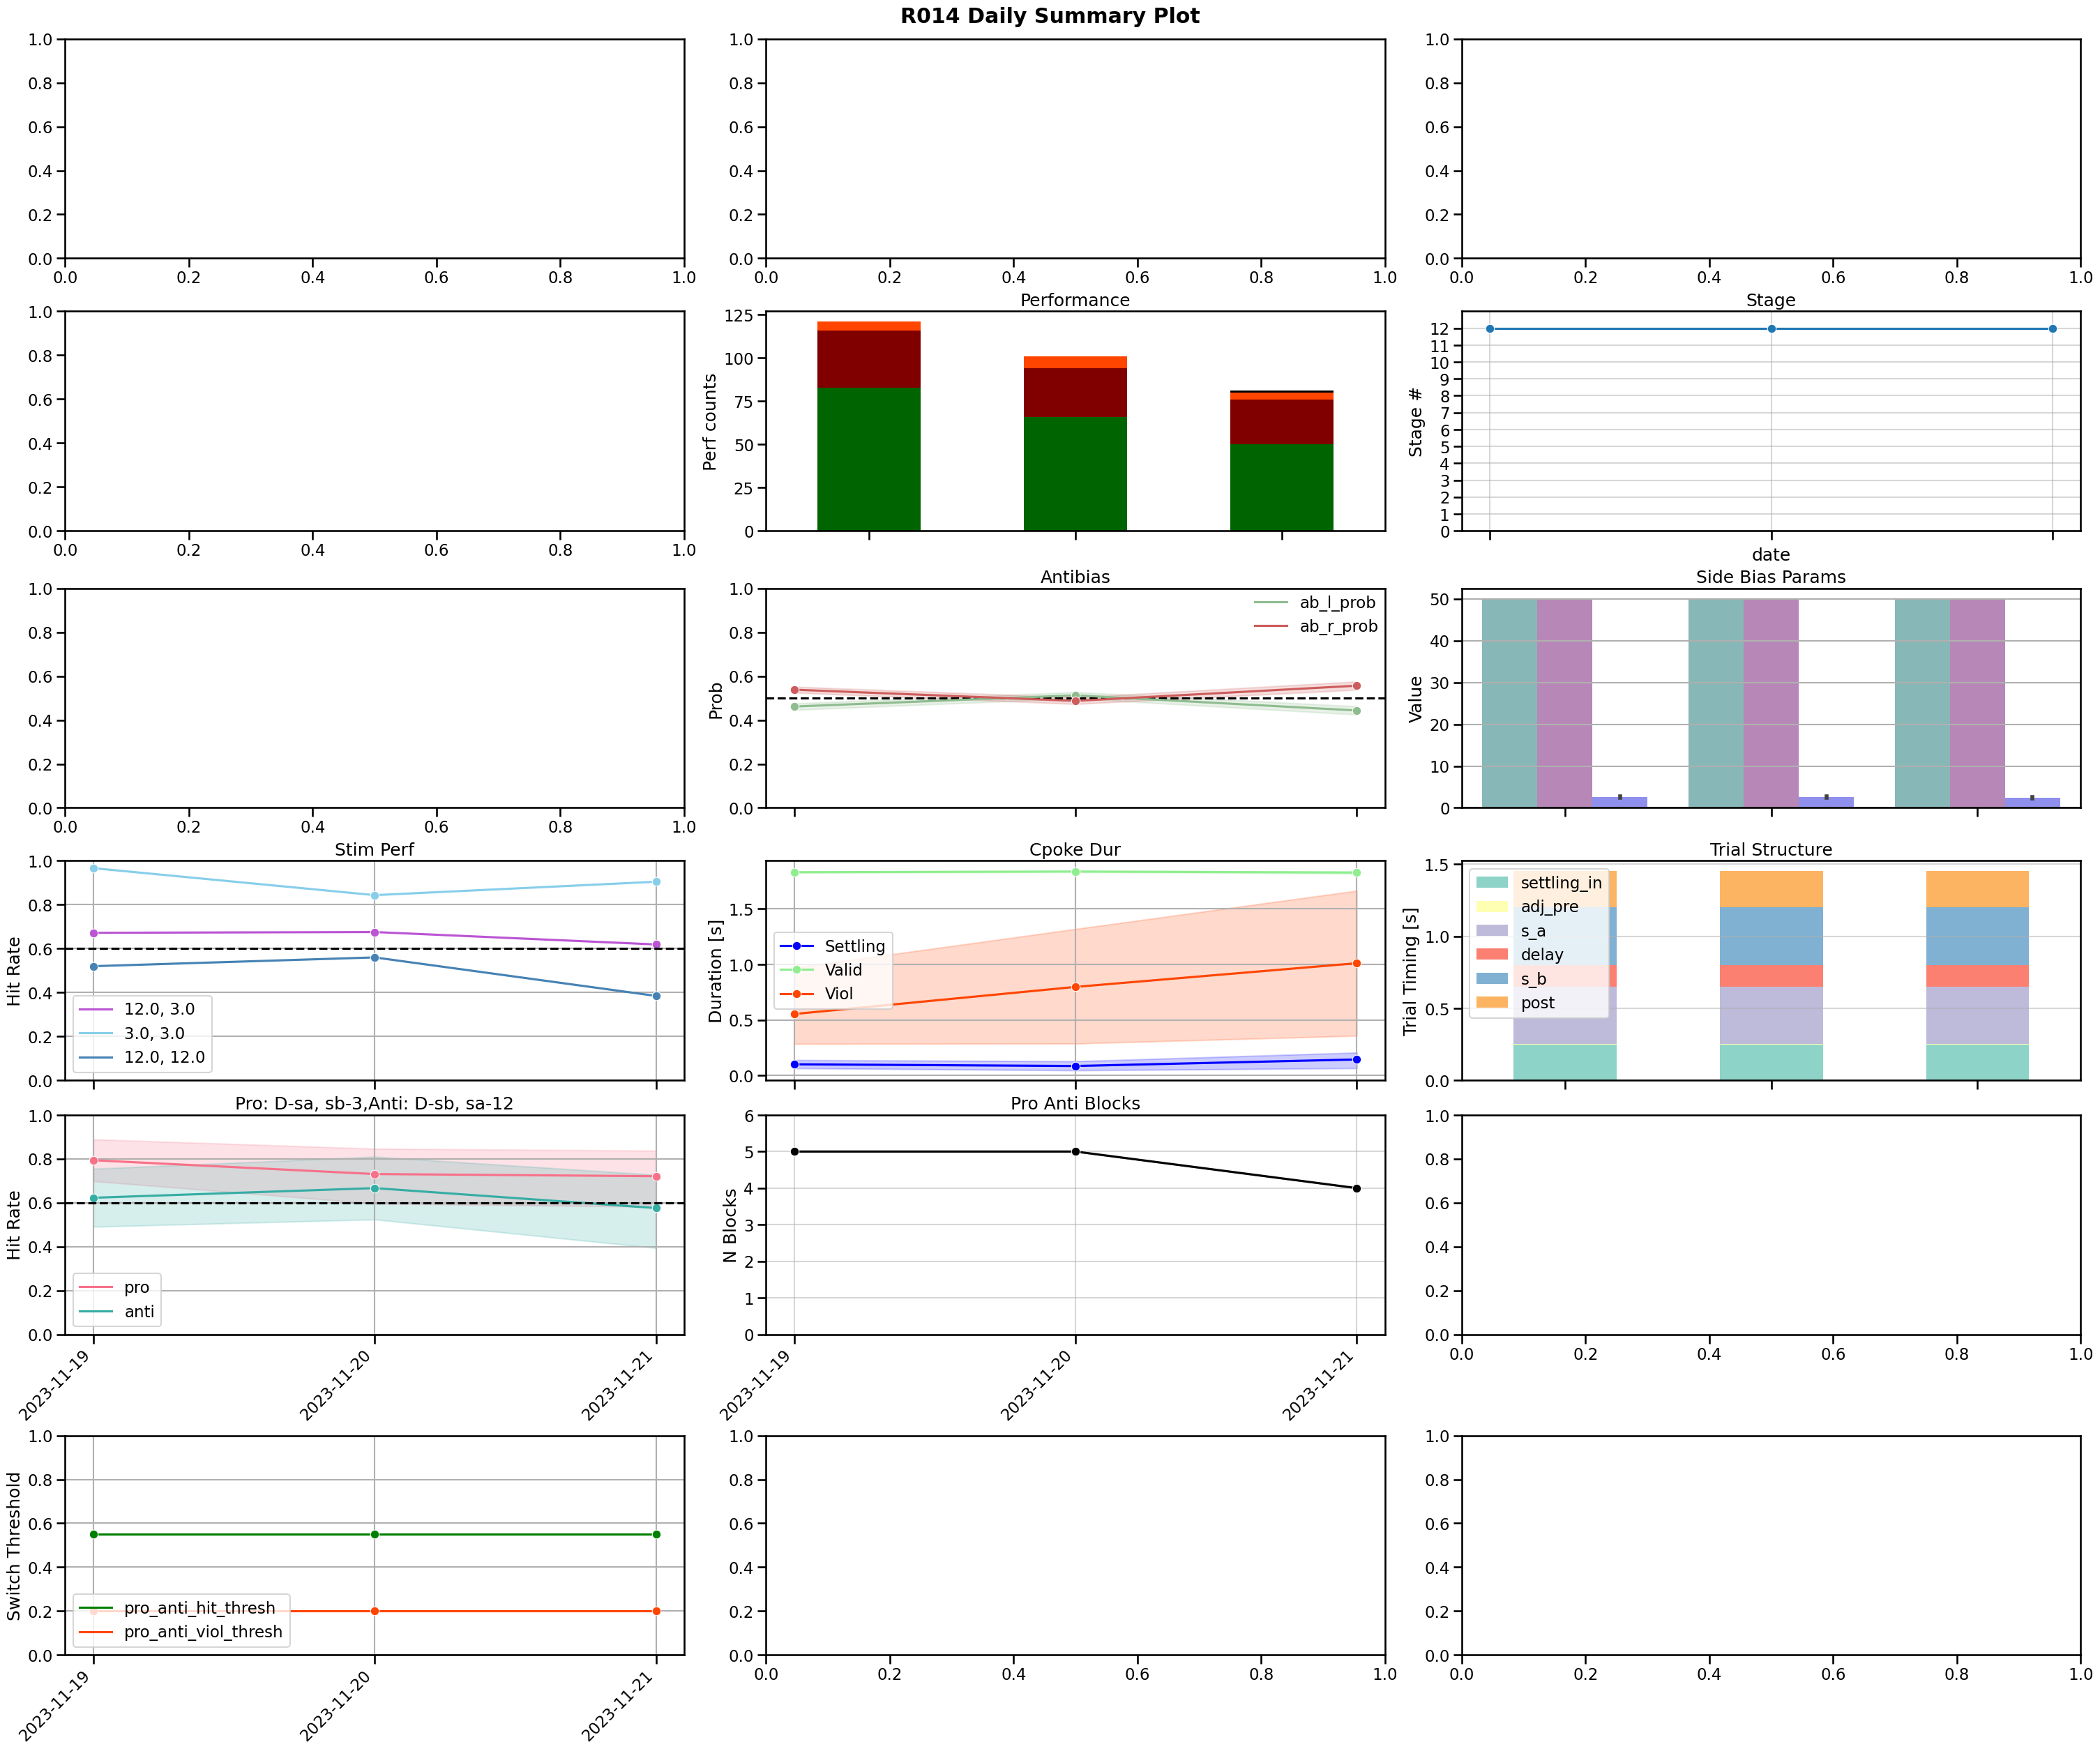

In [226]:
def multiplot_multi_day_summary(animal_id, days_df, trials_df):
    """
    params
    ------
    animal_id : str
        animal id to plot, e.g. "R610"
    days_df : pd.DataFrame
        days dataframe created by create_days_df_from_dj() with
        day as row index
    trials_df : pd.DataFrame
        trials dataframe created by create_trials_df_from_dj() with
        trial as row index

    """
    layout = """
        AAABBBCCC
        DDDEEEFFF
        GGGHHHIII
        JJJKKKLLL
        MMMNNNOOO
        PPPQQQRRR
    """
    fig = plt.figure(constrained_layout=True, figsize=(30, 25))
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    plt.suptitle(f"{animal_id} Daily Summary Plot", fontweight="semibold")

    # animal_days_df = days_df.query("animal_id == @animal_id").copy()
    animal_trials_df = trials_df.query("animal_id == @animal_id").copy()

    ## ROW 1
    # plot_trials(
    #     animal_days_df, ax_dict["A"], title="Trials", legend=True, xaxis_label=False
    # )
    # plot_mass(animal_days_df, ax_dict["B"], title="Mass", xaxis_label=False)
    # plot_water_restriction(
    #     animal_days_df, ax_dict["C"], title="Water", legend=False, xaxis_label=False
    # )

    ## ROW 2
    # # plot_performance(
    #     # animal_days_df, ax_dict["D"], title="Performance", xaxis_label=False
    # )
    plot_performance_bars(
        animal_trials_df, ax_dict["E"], title="Performance", xaxis_label=False
    )
    plot_stage(
        animal_trials_df,
        ax_dict["F"],
        title="Stage",
        xaxis_label=False,
    )

    ## ROW 3
    # plot_side_bias(animal_days_df, ax_dict["G"], title="Side Bias", xaxis_label=False)
    plot_antibias_probs(
        animal_trials_df, ax_dict["H"], title="Antibias", xaxis_label=False
    )
    plot_sidebias_params(
        animal_trials_df, ax_dict["I"], title="Side Bias Params", xaxis_label=False
    )

    ## ROW 4
    if animal_trials_df.stage.iloc[-1] == 9:
        plot_sounds_info(
            animal_trials_df, ax_dict["J"], title="Sounds", xaxis_label=False
        )
    elif animal_trials_df.stage.iloc[-1] == 10 or animal_trials_df.stage.iloc[-1] == 11:
        plot_non_give_stim_performance(
            animal_trials_df, ax_dict["J"], title="Non-Give Perf", xaxis_label=False
        )
    elif animal_trials_df.stage.iloc[-1] > 11:
        plot_stim_performance(
            animal_trials_df, ax_dict["J"], title="Stim Perf", xaxis_label=False
        )
    else:
        plot_time_to_spoke(
            animal_trials_df, ax_dict["J"], title="Time to Spoke", xaxis_label=False
        )
    # j is perf either by give or stim depd
    # k stays, # l becomes timing
    # k cpoke dur, # l timing
    # m becomes give metric or pro/anti perf
    # n is multi cpokes or pro/anti
    # o is rig/tech
    if animal_trials_df.SMA_set.iloc[-1] == "cpoke":
        plot_cpoke_dur_timings_pregnp(
            animal_trials_df, ax_dict["K"], title="Cpoke Dur", xaxis_label=False
        )
        plot_trial_structure(
            animal_trials_df, ax_dict["L"], title="Trial Structure", xaxis_label=False
        )

    ## ROW 5
    if animal_trials_df.SMA_set.iloc[-1] == "cpoke":
        if (
            animal_trials_df.stage.iloc[-1] == 10
            or animal_trials_df.stage.iloc[-1] == 11
        ):
            plot_performance_by_give(
                animal_trials_df, ax_dict["M"], title="Give Metrics", xaxis_label=True
            )

            plot_n_cpokes_and_multirate(
                animal_trials_df, ax_dict["N"], title="Multi Cpokes", xaxis_label=True
            )

        elif animal_trials_df.stage.iloc[-1] > 11:
            plot_stim_performance_by_pro_anti(
                animal_trials_df,
                ax_dict["M"],
                title=f"Pro: {animal_trials_df.pro_stim_set.dropna().unique()[0]},Anti: {animal_trials_df.anti_stim_set.dropna().unique()[0]}",
                xaxis_label=True,
            )

            plot_n_pro_anti_blocks_days(
                animal_trials_df,
                ax_dict["N"],
                title="Pro Anti Blocks",
                xaxis_label=True,
            )
        else:
            plot_give_info_days(
                animal_trials_df,
                ax_dict["M"],
                title="Give Type",
                xaxis_label=True,
                legend=False,
            )
            plot_n_cpokes_and_multirate(
                animal_trials_df, ax_dict["N"], title="Multi Cpokes", xaxis_label=True
            )

    # plot_rig_tech(animal_days_df, ax_dict["O"], title="Rig Tech", xaxis_label=True)

    if animal_trials_df.stage.iloc[-1] > 10:
        plot_block_switch_thresholds(animal_trials_df, ax_dict["P"])

    return None


multiplot_multi_day_summary("R014", None, trials_df)

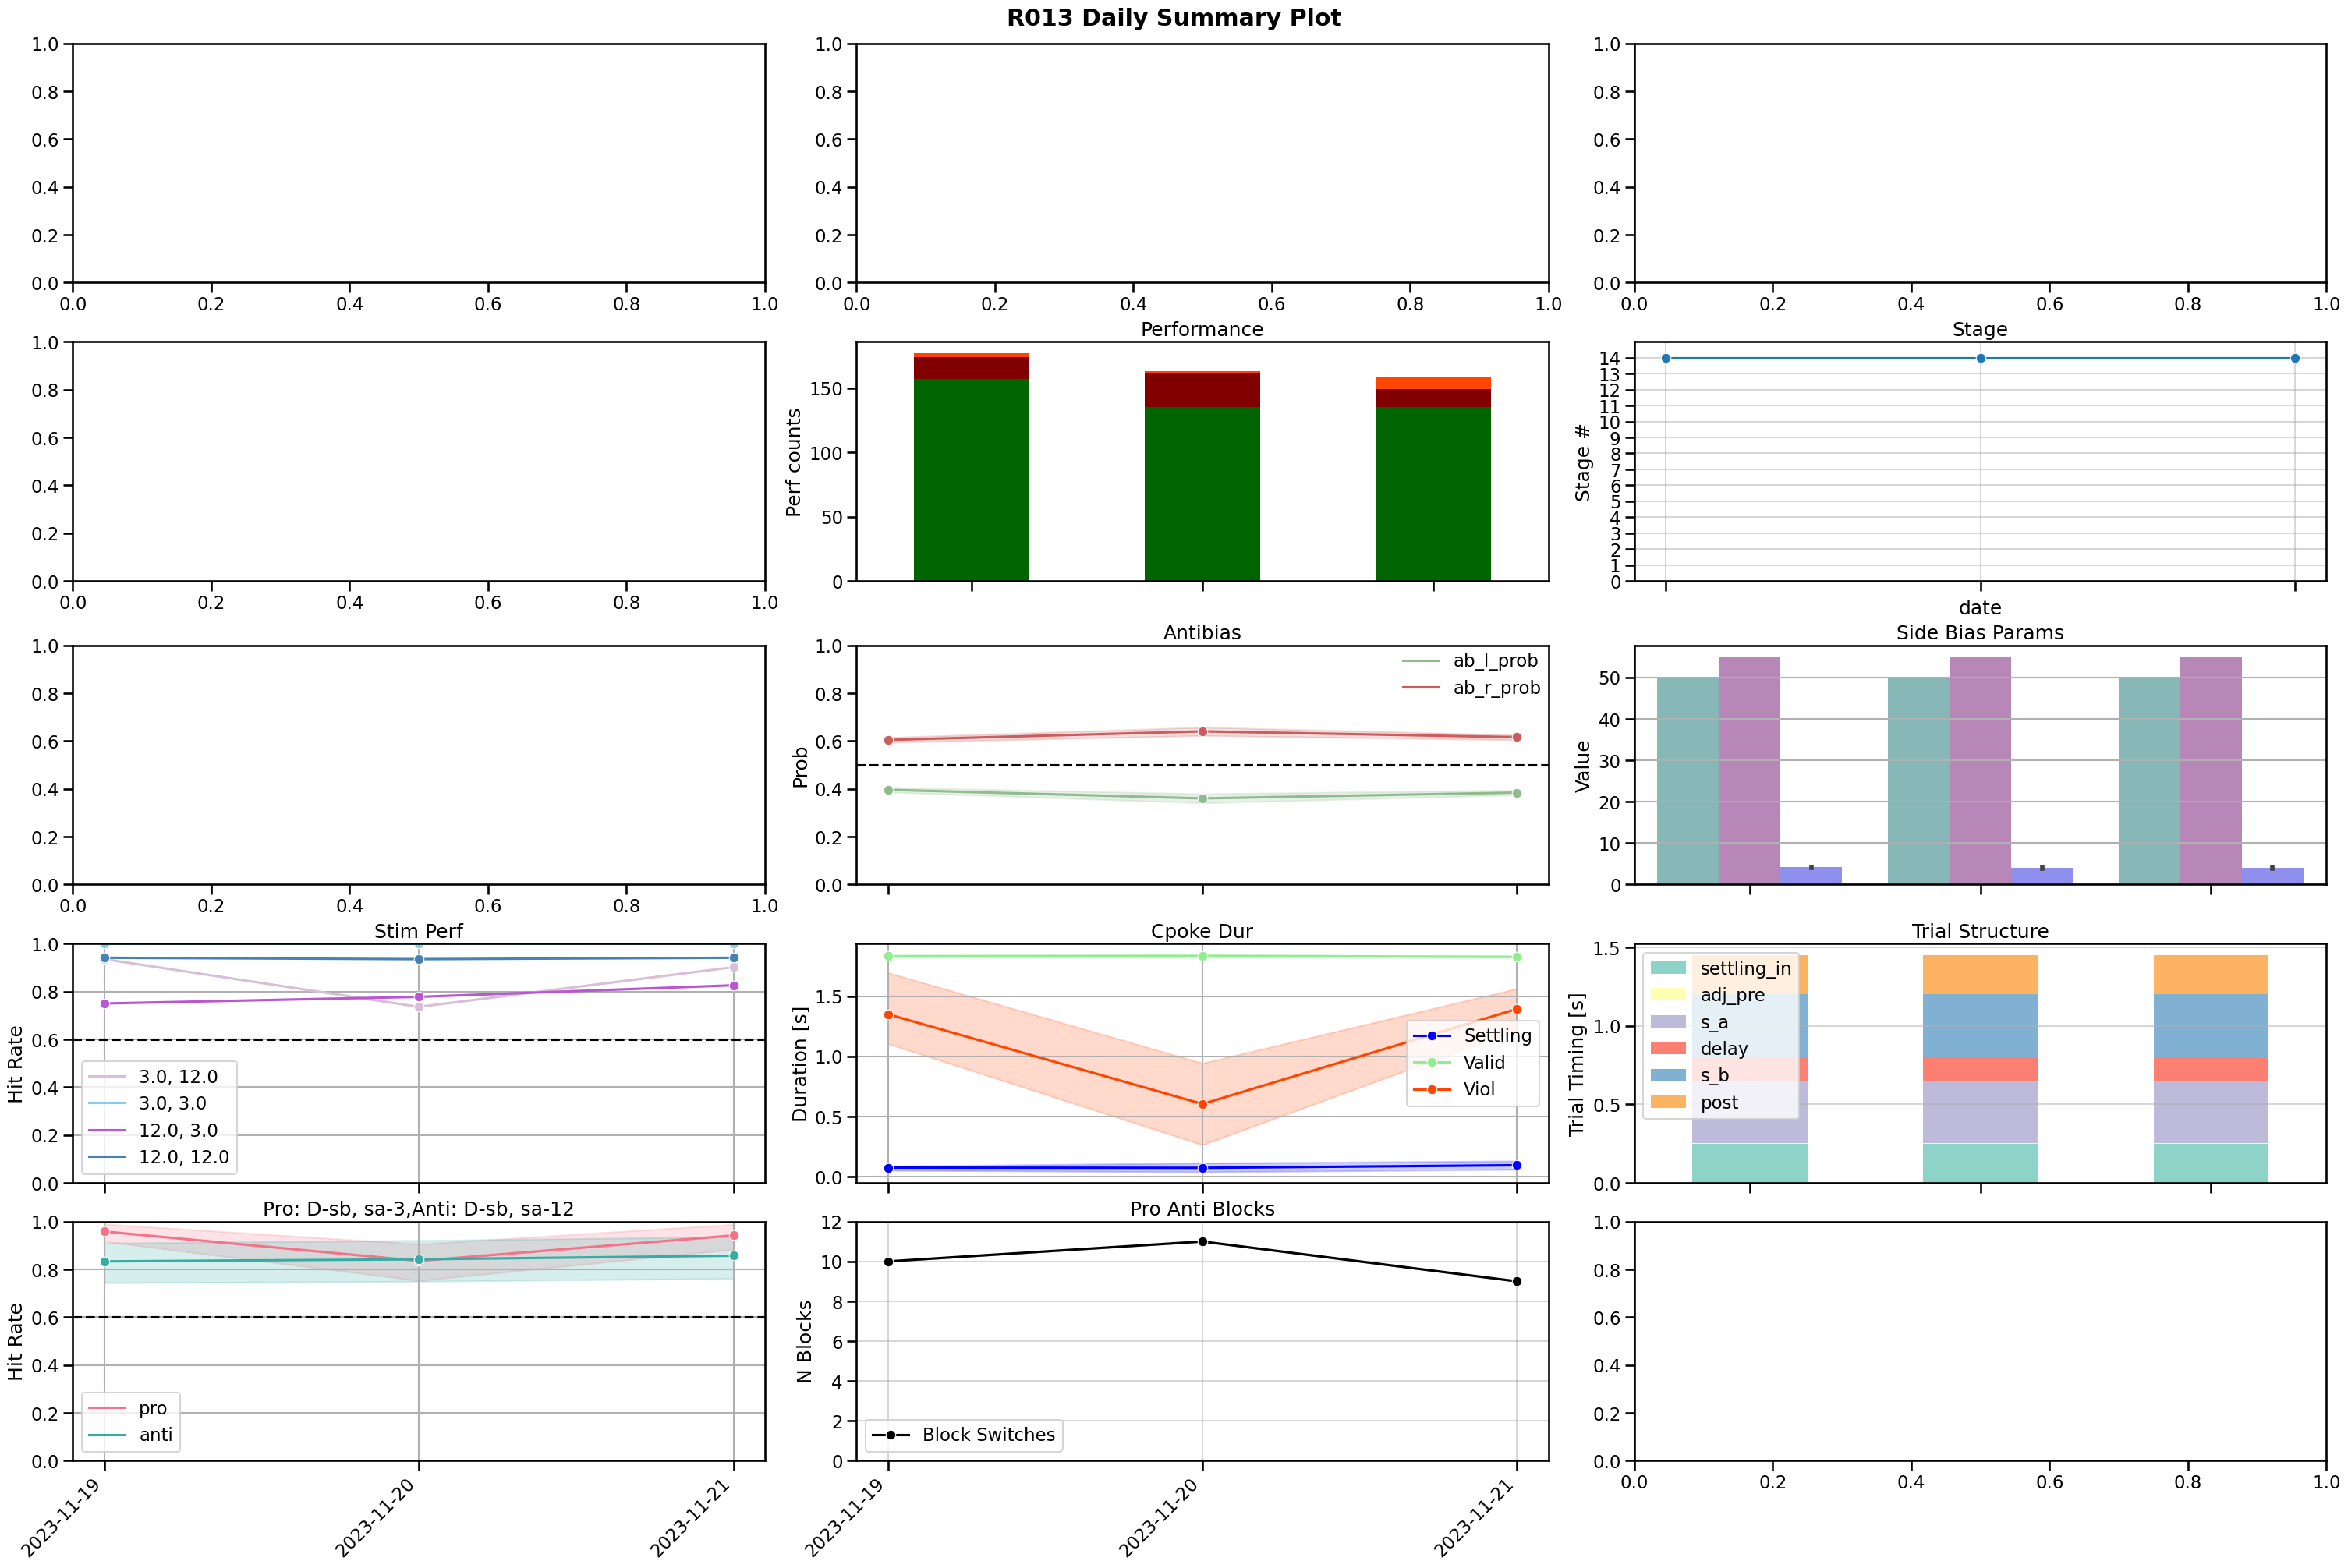

In [325]:
def multiplot_multi_day_summary_og(animal_id, days_df, trials_df):
    """
    params
    ------
    animal_id : str
        animal id to plot, e.g. "R610"
    days_df : pd.DataFrame
        days dataframe created by create_days_df_from_dj() with
        day as row index
    trials_df : pd.DataFrame
        trials dataframe created by create_trials_df_from_dj() with
        trial as row index

    """
    layout = """
        AAABBBCCC
        DDDEEEFFF
        GGGHHHIII
        JJJKKKLLL
        MMMNNNOOO
    """
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    plt.suptitle(f"{animal_id} Daily Summary Plot", fontweight="semibold")

    # animal_days_df = days_df.query("animal_id == @animal_id").copy()
    animal_trials_df = trials_df.query("animal_id == @animal_id").copy()

    ## ROW 1
    # plot_trials(
    #     animal_days_df, ax_dict["A"], title="Trials", legend=True, xaxis_label=False
    # )
    # plot_mass(animal_days_df, ax_dict["B"], title="Mass", xaxis_label=False)
    # plot_water_restriction(
    #     animal_days_df, ax_dict["C"], title="Water", legend=False, xaxis_label=False
    # )

    ## ROW 2
    # # plot_performance(
    #     # animal_days_df, ax_dict["D"], title="Performance", xaxis_label=False
    # )
    plot_performance_bars(
        animal_trials_df, ax_dict["E"], title="Performance", xaxis_label=False
    )
    plot_stage(
        animal_trials_df,
        ax_dict["F"],
        title="Stage",
        xaxis_label=False,
    )

    ## ROW 3
    # plot_side_bias(animal_days_df, ax_dict["G"], title="Side Bias", xaxis_label=False)
    plot_antibias_probs(
        animal_trials_df, ax_dict["H"], title="Antibias", xaxis_label=False
    )
    plot_sidebias_params(
        animal_trials_df, ax_dict["I"], title="Side Bias Params", xaxis_label=False
    )

    ## ROW 4
    if animal_trials_df.stage.iloc[-1] == 9:
        plot_sounds_info(
            animal_trials_df, ax_dict["J"], title="Sounds", xaxis_label=False
        )
    elif animal_trials_df.stage.iloc[-1] == 10 or animal_trials_df.stage.iloc[-1] == 11:
        plot_non_give_stim_performance(
            animal_trials_df, ax_dict["J"], title="Non-Give Perf", xaxis_label=False
        )
    elif animal_trials_df.stage.iloc[-1] > 11:
        plot_stim_performance(
            animal_trials_df, ax_dict["J"], title="Stim Perf", xaxis_label=False
        )
    else:
        plot_time_to_spoke(
            animal_trials_df, ax_dict["J"], title="Time to Spoke", xaxis_label=False
        )
    # j is perf either by give or stim depd
    # k stays, # l becomes timing
    # k cpoke dur, # l timing
    # m becomes give metric or pro/anti perf
    # n is multi cpokes or pro/anti
    # o is rig/tech
    if animal_trials_df.SMA_set.iloc[-1] == "cpoke":
        plot_cpoke_dur_timings_pregnp(
            animal_trials_df, ax_dict["K"], title="Cpoke Dur", xaxis_label=False
        )
        plot_trial_structure(
            animal_trials_df, ax_dict["L"], title="Trial Structure", xaxis_label=False
        )

    ## ROW 5
    if animal_trials_df.SMA_set.iloc[-1] == "cpoke":
        if (
            animal_trials_df.stage.iloc[-1] == 10
            or animal_trials_df.stage.iloc[-1] == 11
        ):
            plot_performance_by_give(
                animal_trials_df, ax_dict["M"], title="Give Metrics", xaxis_label=True
            )

            plot_n_cpokes_and_multirate(
                animal_trials_df, ax_dict["N"], title="Multi Cpokes", xaxis_label=True
            )

        elif animal_trials_df.stage.iloc[-1] > 11:
            plot_stim_performance_by_pro_anti(
                animal_trials_df,
                ax_dict["M"],
                title=f"Pro: {animal_trials_df.pro_stim_set.dropna().unique()[0]},Anti: {animal_trials_df.anti_stim_set.dropna().unique()[0]}",
                xaxis_label=True,
            )

            plot_n_pro_anti_blocks_days(
                animal_trials_df,
                ax_dict["N"],
                title="Pro Anti Blocks",
                xaxis_label=True,
            )
        else:
            plot_give_info_days(
                animal_trials_df,
                ax_dict["M"],
                title="Give Type",
                xaxis_label=True,
                legend=False,
            )
            plot_n_cpokes_and_multirate(
                animal_trials_df, ax_dict["N"], title="Multi Cpokes", xaxis_label=True
            )

    # plot_rig_tech(animal_days_df, ax_dict["O"], title="Rig Tech", xaxis_label=True)

    # if animal_trials_df.stage.iloc[-1] > 10:
    #     plot_block_switch_thresholds(animal_trials_df, ax_dict["P"])

    return None


multiplot_multi_day_summary_og("R013", None, trials_df)

['s_a', 'go']


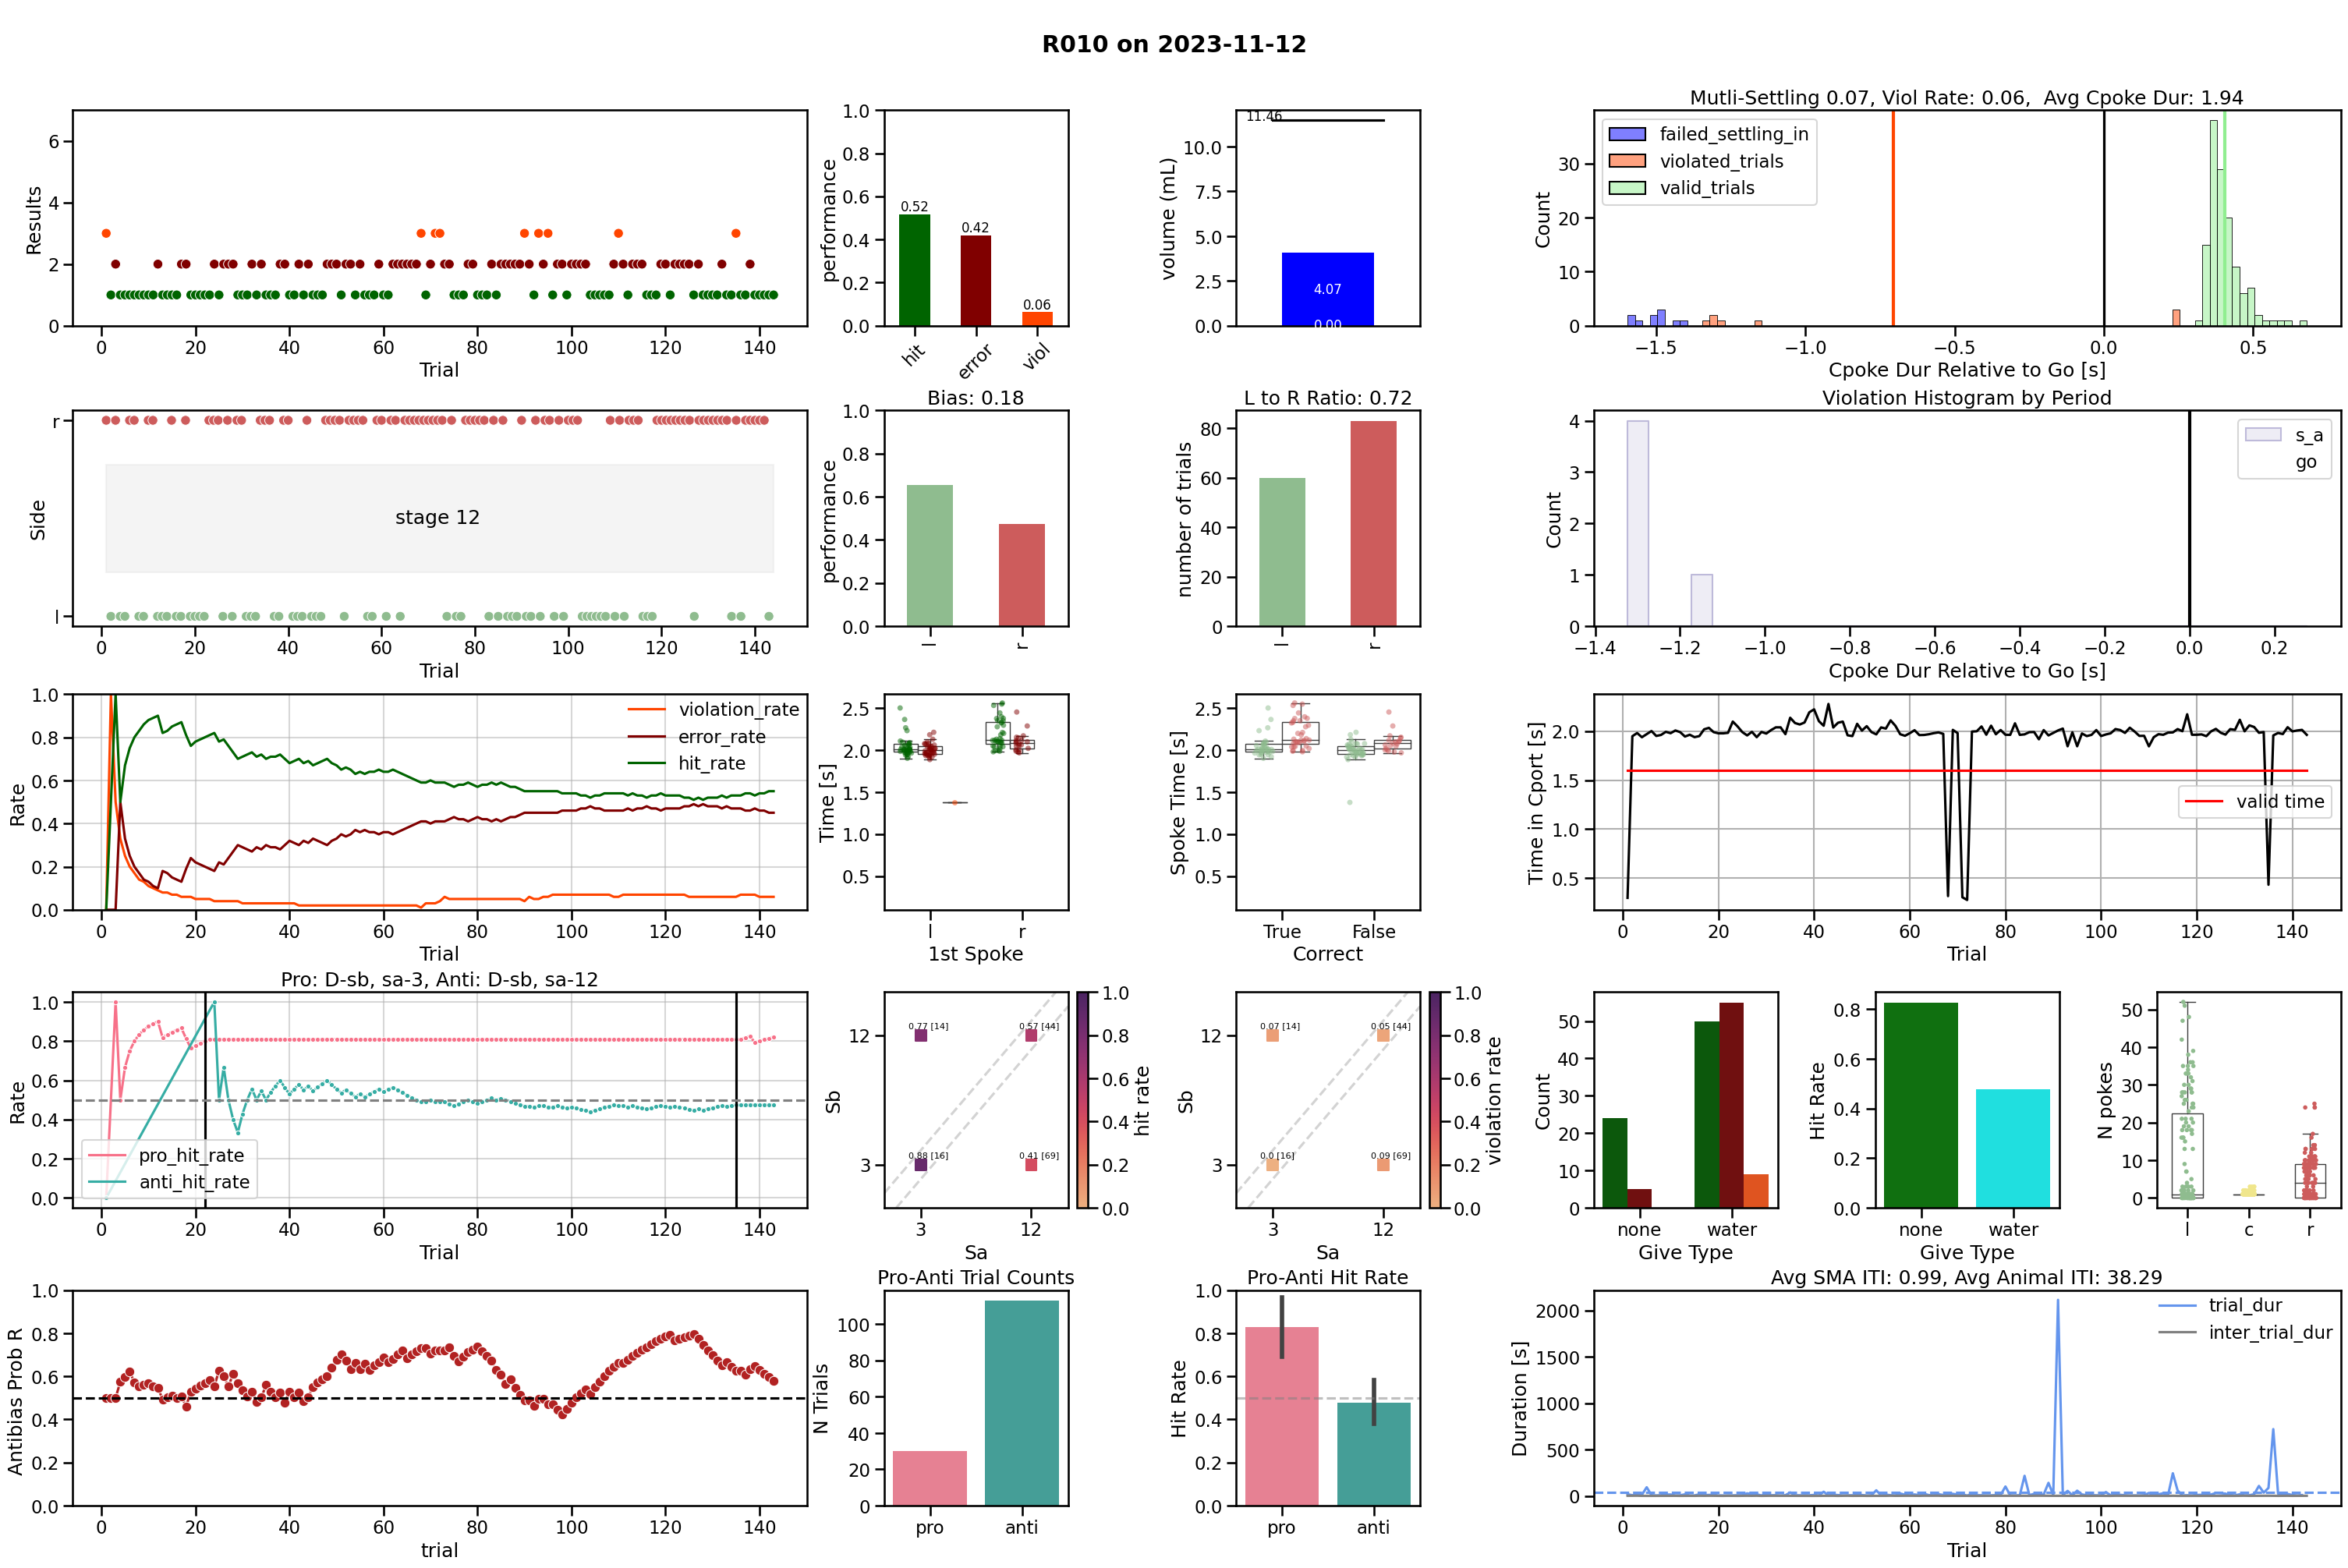

In [ ]:
mutliplot_cpoke_pro_anti(trials_df)

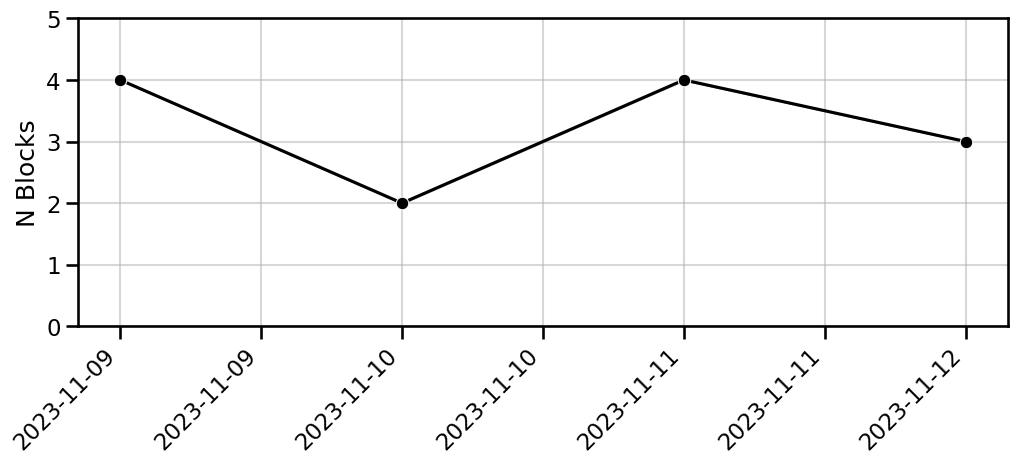

In [126]:
fig, ax = pu.make_fig()


plot_n_pro_anti_blocks_days(days_trials_df, ax)

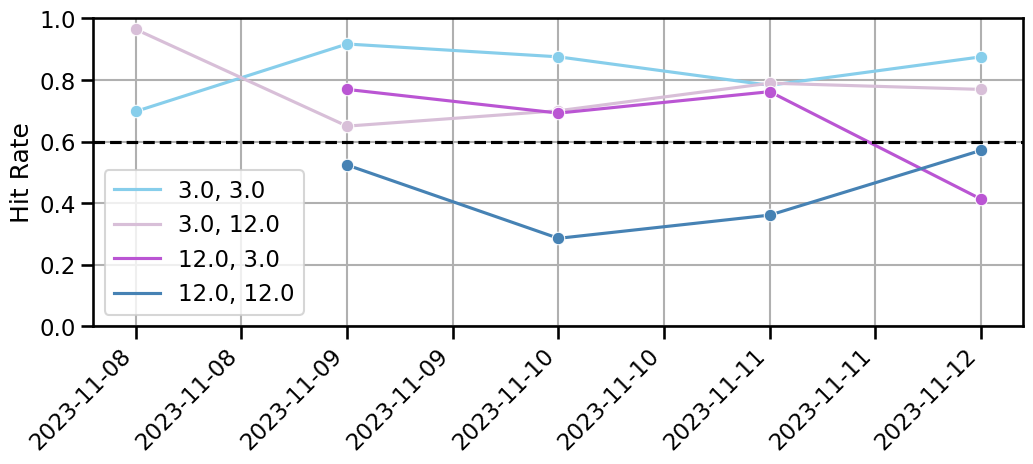

In [110]:
fig, ax = pu.make_fig()
plot_stim_performance(days_trials_df, ax)

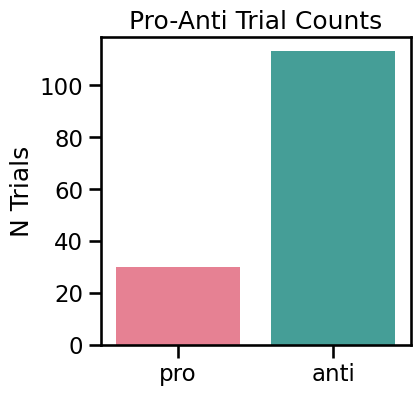

In [200]:



plot_pro_anti_count_summary(trials_df)

In [173]:
trials_df.dropna(inplace=True)

trials_df

,trial,animal_id,date,sess_id,result,hits,violations,temperror,hit_rate,error_rate,...,r_water_vol,ab_l_prob,ab_r_prob,ab_beta,ab_tau,exp_del_tau,exp_del_min,exp_del_max,sound_pair,min_time_to_spoke


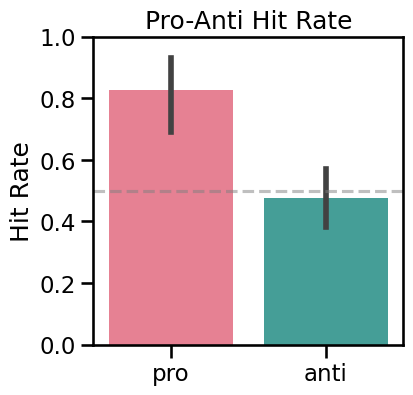

In [196]:
fig, ax = pu.make_fig("s")





plot_hit_rate_by_pro_anti(trials_df, ax)

TypeError: boolean value of NA is ambiguous

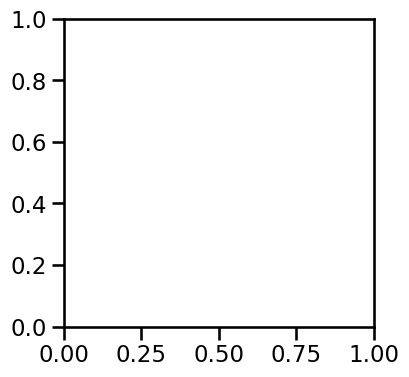

In [159]:
fig, ax = pu.make_fig("s")
hit_rate_by_pro_anti = (
    trials_df.groupby("pro_anti_block_type").hits.mean().reset_index()
)
sns.barplot(
    data=trials_df,
    x="pro_anti_block_type",
    y="hits",
    ax=ax,
    # hue="pro_anti_block_type",
    # dodge=False,
    # palette="husl",
    # hue_order=["pro", "anti"],
)

ax.axhline(0.5, ls="--", color="gray", alpha=0.5)
_ = ax.set(
    xlabel="",
    ylabel="Hit Rate",
    title="Pro-Anti Trial Counts",
    ylim=(0, 1),
)

ax.legend().remove()

In [153]:
def plot_pro_anti_count_summary(trials_df, ax, title=""):
    """
    plot the count of pro/anti types implemented and color by
    what was actually set in the GUI

    params
    ------
    trials_df : pandas.DataFrame
        trials dataframe with columns `give_type_imp` and `give_type_set`
        with trials as row index
    ax : matplotlib.axes
        axis to plot to
    """

    return None

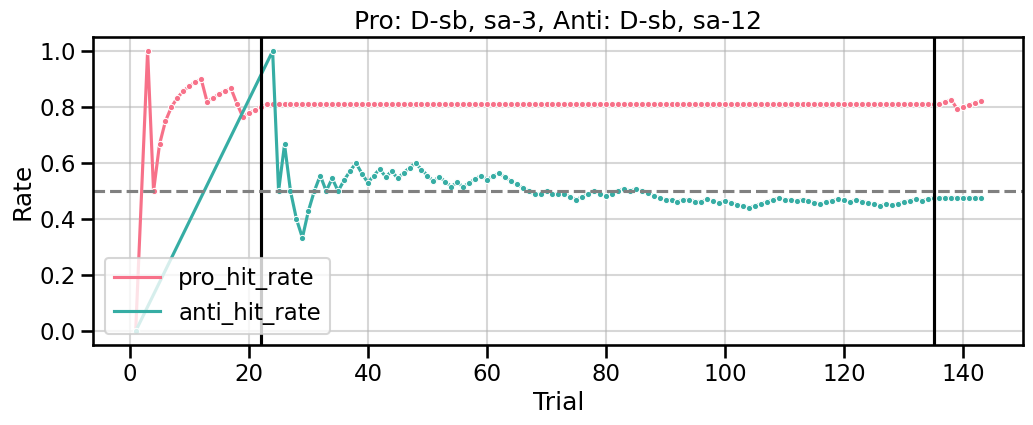

In [86]:
fig, ax = pu.make_fig()
plot_pro_anti_perf_rates(trials_df, ax=ax)

In [19]:
multi_day_trials_df = create_trials_df_from_dj(
    animal_ids=ANIMAL_IDS, date_min="2023-08-01"
)

fetched 23 sessions for R015 between 2023-08-01 and 2023-08-31


In [46]:
def mutliplot_cpoke_decrease_give(trials_df, save_out=False, save_path=None):
    """
    generate summary plot for cpoke stages sounds are just being turned on
    the key thing to visualize here is the duration of the sound stimuli
    relative to the delay & the violation rate wrt periods

    params
    ------
    trials_df : DataFrame
        trials dataframe generated by create_trials_df() for a single
        animal on a single date with trials as row index
    save_out : bool (default=False)
        whether to save out the figure
    save_path : str (default=None)
        path to save the figure to
    """
    layout = """
        AAABCDDD
        EEEFGHHH
        IIIJKLLL
        MMMNOPQR
        SSSTUVVV
    """
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))

    plt.suptitle(
        f"\n{trials_df.animal_id.iloc[0]} on {trials_df.date.iloc[0]}\n",
        fontweight="semibold",
    )
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    # pu.identify_axes(ax_dict)  # prints the letter for id

    ## ROW 1
    plot_results(trials_df, ax=ax_dict["A"])
    plot_result_summary(trials_df, ax=ax_dict["B"])
    plot_watering_amounts(trials_df, ax=ax_dict["C"])
    plot_cpoke_distributions(trials_df, ax=ax_dict["D"], mode="violations")

    ## ROW 2
    plot_correct_side(trials_df, ax=ax_dict["E"])
    plot_stage_info(trials_df, ax=ax_dict["E"])
    plot_side_bias_summary(trials_df, ax=ax_dict["F"])
    plot_side_count_summary(trials_df, ax=ax_dict["G"])
    plot_violations_by_period(trials_df, ax=ax_dict["H"])

    ## ROW 3
    plot_performance_rates(trials_df, ax=ax_dict["I"])
    plot_first_spoke_summary_by_loc_and_result(trials_df, ax=ax_dict["J"])
    plot_first_spokes_summary_by_correct_side_and_loc(trials_df, ax=ax_dict["K"])
    plot_cpokes_over_trials(trials_df, ax=ax_dict["L"], mode="violations")

    ## ROW 4
    plot_give_info(trials_df, ax=ax_dict["M"])
    plot_stim_grid_performance(trials_df, ax=ax_dict["N"], mode="hits")
    plot_stim_grid_performance(trials_df, ax=ax_dict["O"], mode="violations")
    plot_result_by_give(trials_df, ax=ax_dict["P"])
    plot_hit_rate_by_give(trials_df, ax=ax_dict["Q"])
    plot_npokes_summary(trials_df, ax=ax_dict["R"])

    ## ROW 5
    plot_antibias_r_probs(trials_df, ax=ax_dict["S"])
    plot_stim_grid_performance(
        trials_df.query("give_type_imp == 'none'"),
        ax=ax_dict["T"],
        mode="hits",
        title="Give perf",
    )
    plot_stim_grid_performance(
        trials_df.query("give_type_imp == 'none'"),
        ax=ax_dict["U"],
        mode="violations",
        title="Give perf",
    )
    plot_trial_dur(trials_df, ax=ax_dict["V"])

    if save_out:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close("all")
    else:
        plt.show()

    return None

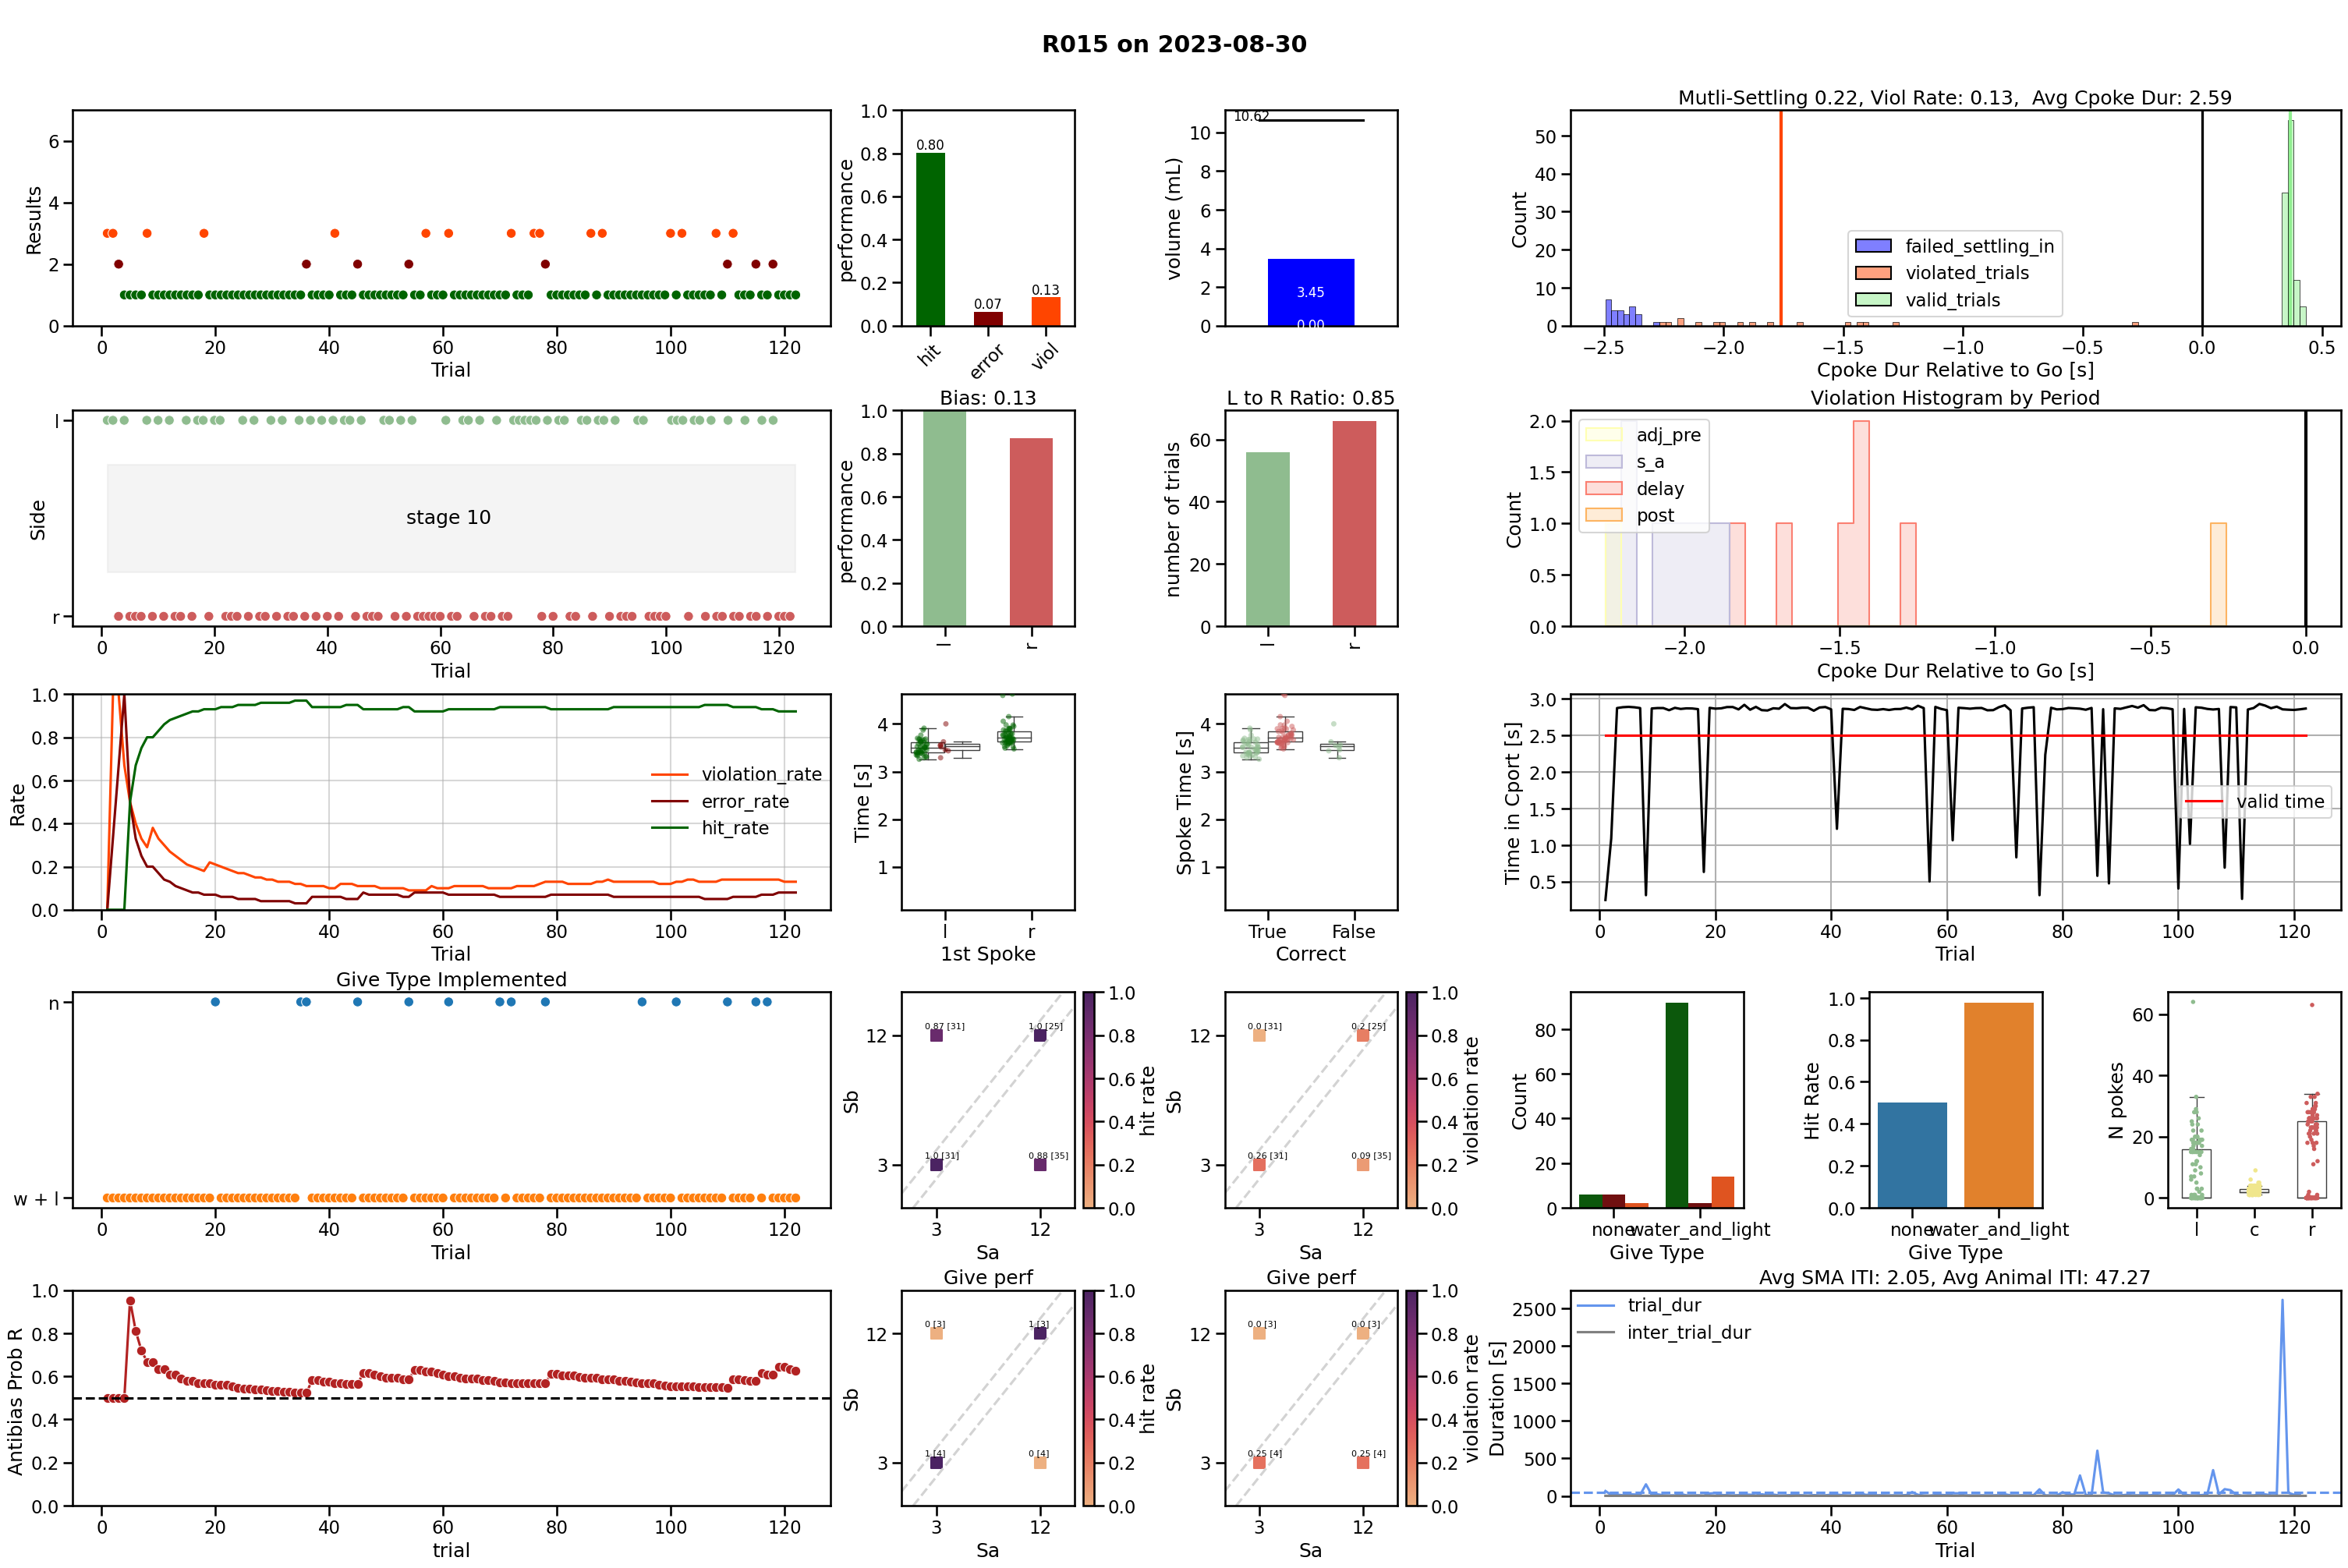

In [47]:
mutliplot_cpoke_decrease_give(trials_df)

final notes:
* will want to test tomorrow if this plot actual works in logic
* will also want to add antibias plot to other earlier stages

In [7]:
FPATH = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/offline/cpoke_dur_debug"
trials_df = pd.read_csv(FPATH + "/r015.csv")
TRIALS = pd.read_csv(FPATH + "/all_cpokes.csv")

In [3]:
# f_name = "R01s_days_df.csv"

# # days_df.to_csv(DATA_PATH / f_name, index=False)


# days_df = lazy_load_days_summary_df(
#     date_min=date_min,
#     date_max="2023-08-02",
#     animal_ids=ANIMAL_IDS,
#     save_dir=DATA_PATH,
#     f_name=f_name,
#     save_out=False,
# )

making R014_2023-08-13_day_summary


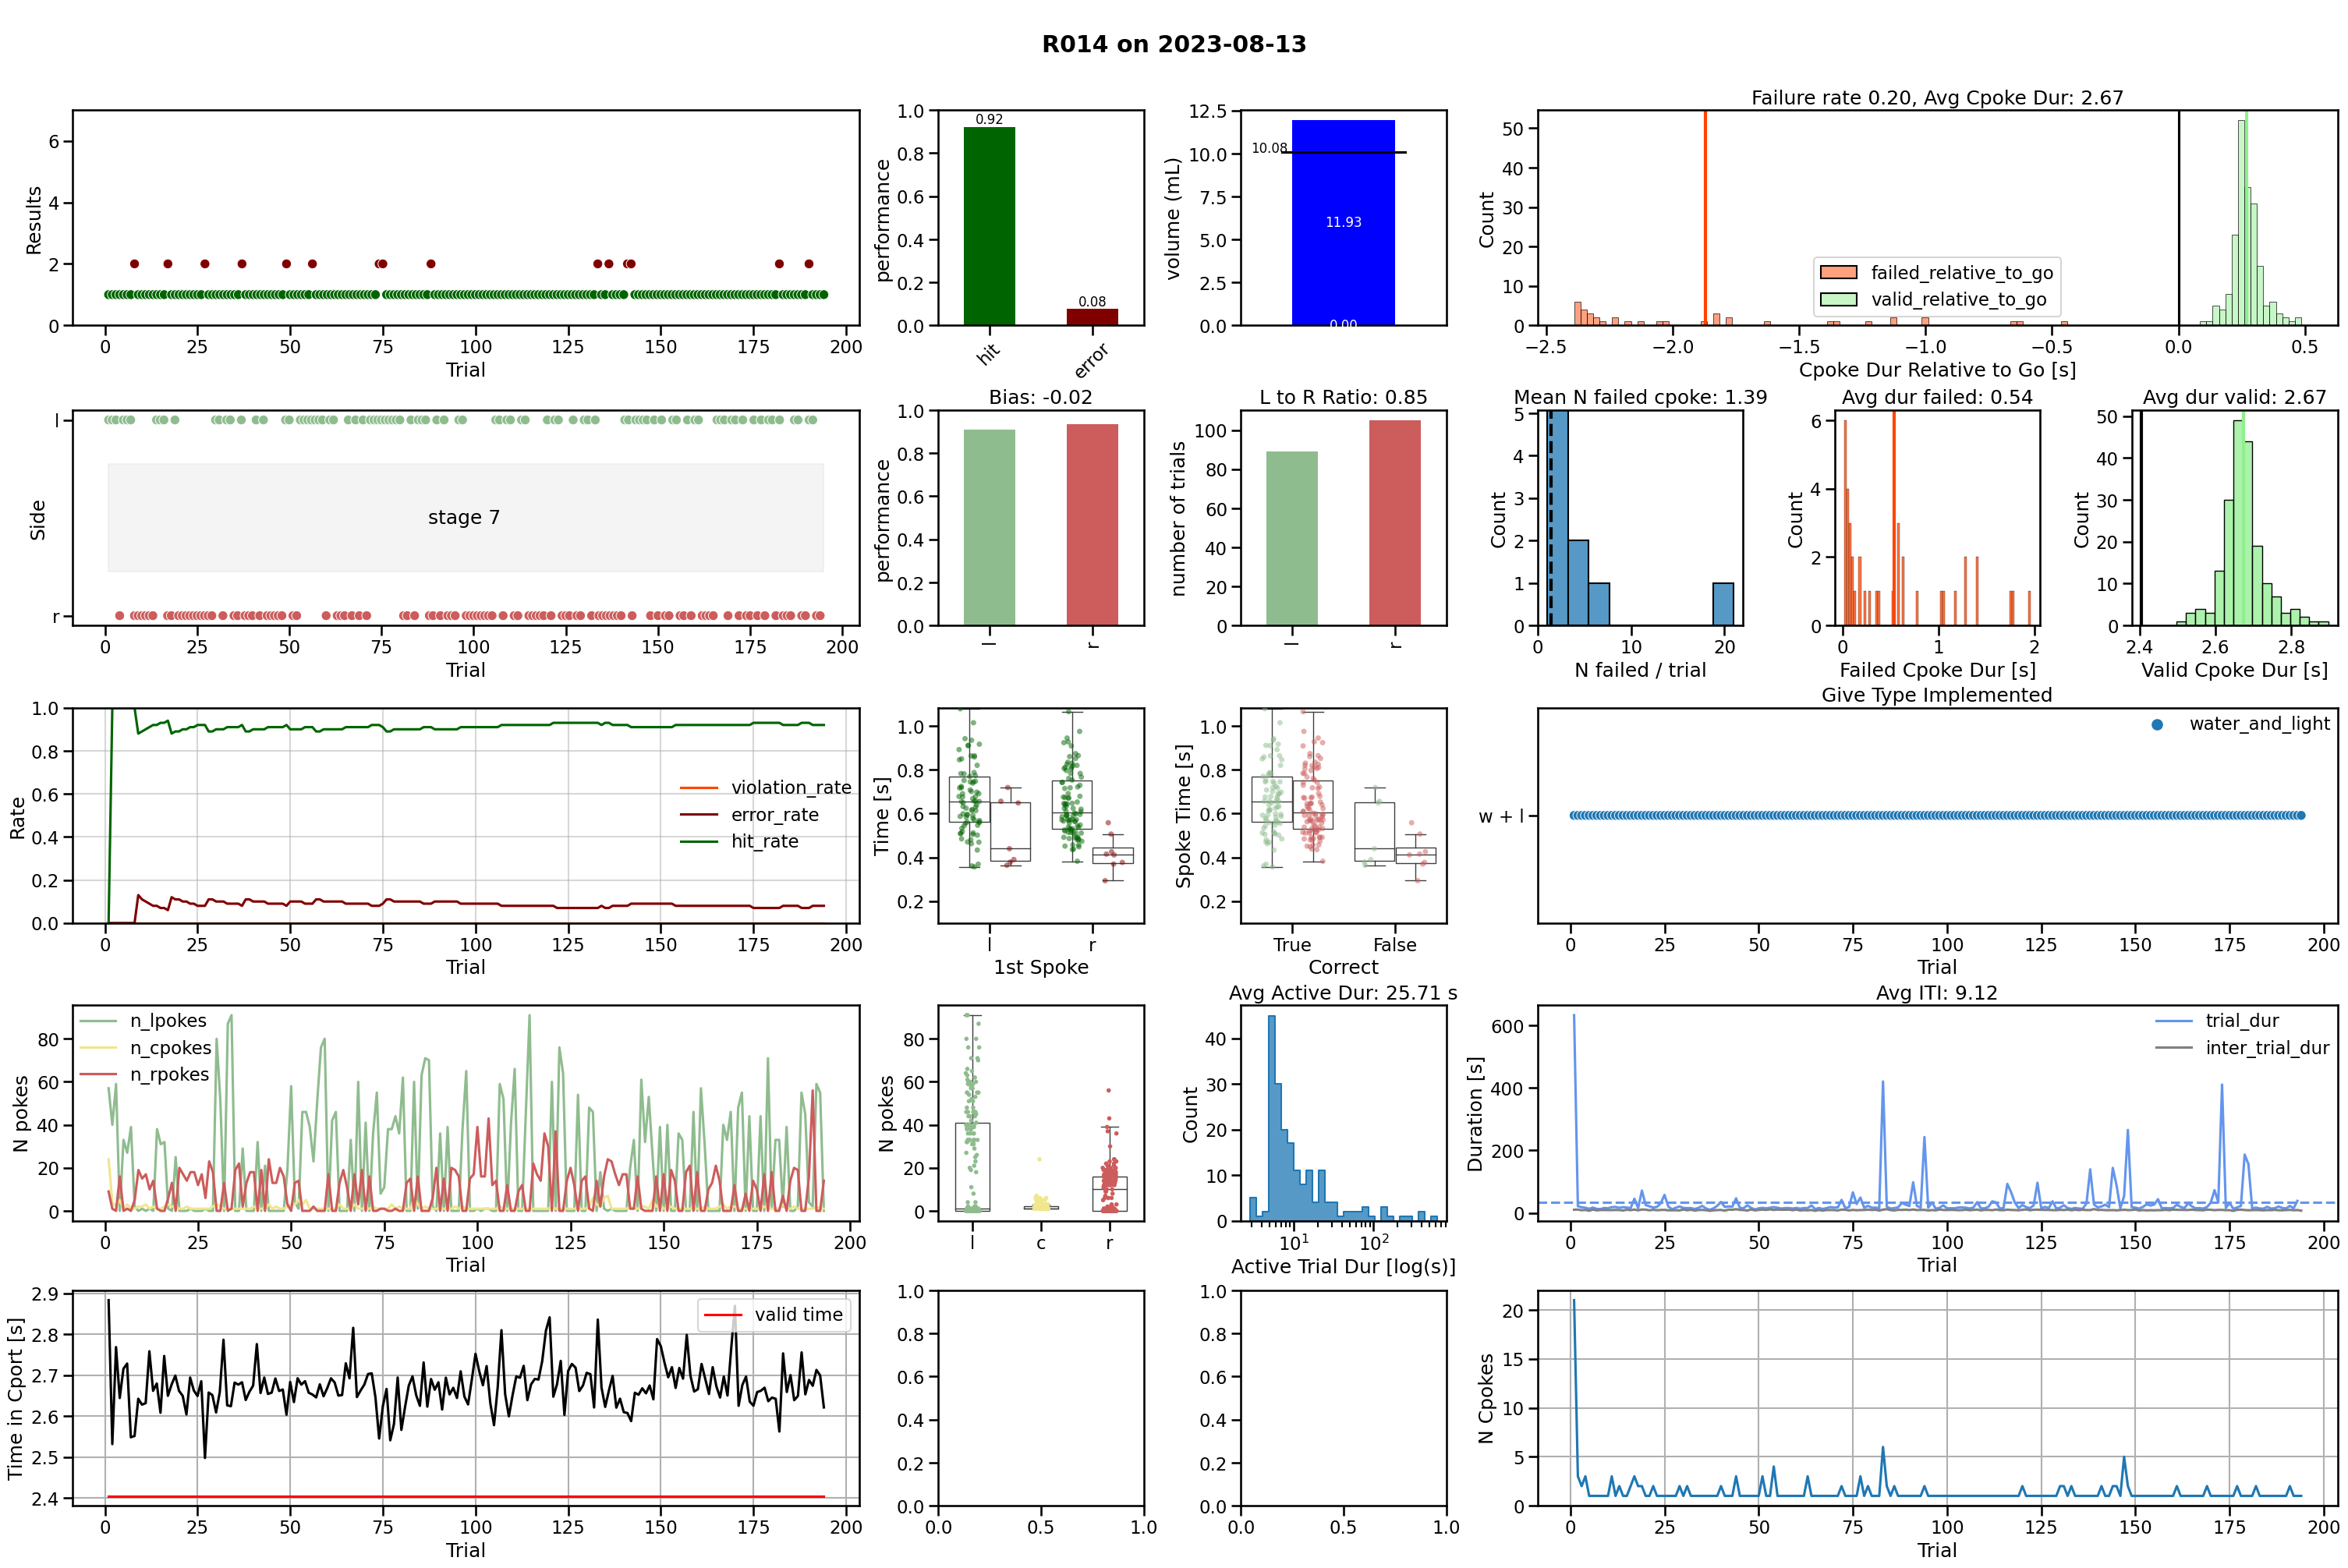

In [18]:
import os

fig_path = Path(
    "/Users/jessbreda/Desktop/github/jbreda_animal_training/code/training_performance"
)
multiplot_single_day_summaries(trials_df, fig_path, save_out=False, overwrite=False)

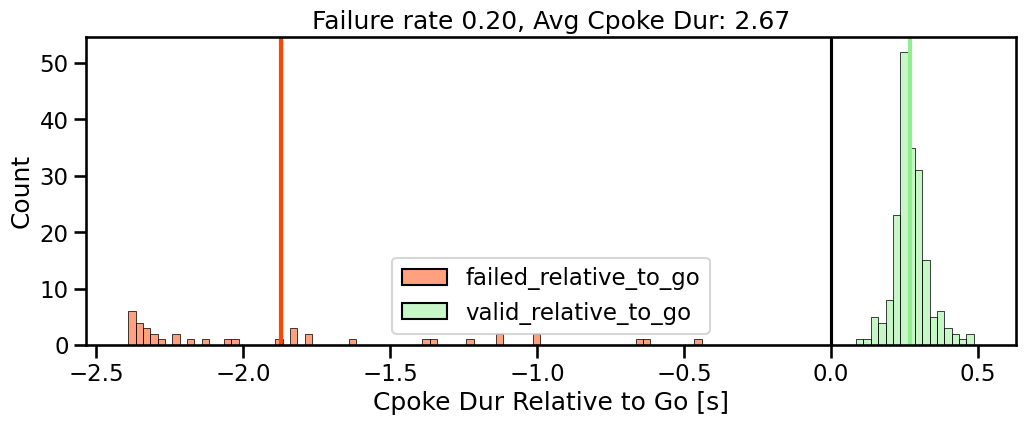

In [5]:
fig, ax = pu.make_fig()
plot_cpoke_distributions(trials_df, ax, mode="settling_in")

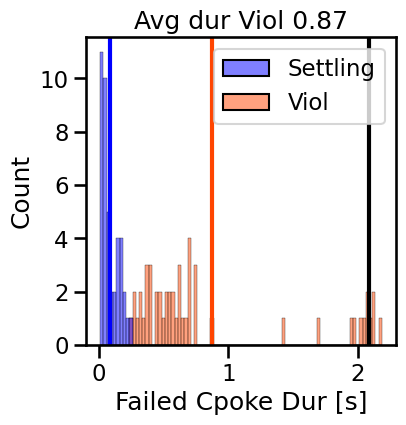

In [23]:
fig, ax = pu.make_fig("s")

plot_avg_failed_cpoke_dur(trials_df, ax, mode="violations")

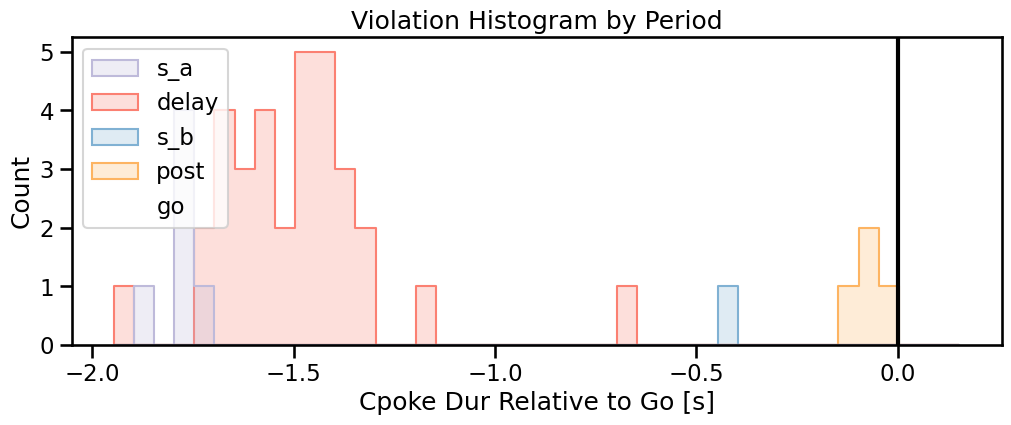

In [44]:
fig, ax = pu.make_fig()
_ = plot_violations_by_period(trials_df, ax)

EXTRA BITS

In [7]:
# plot the viol histogram relative to sa turning on.
# 1. filter for viol trials
# 2. find the time at which sa turned on
# 3. subtract from cpoke dur
# 4. plot histogram

# trials_df = trials_df.query("violations == 1").copy()
# trials_df = trials_df.assign(
#     sa_on_time=trials_df.apply(
#         lambda row: row["settling_in_dur"] + row["settling_in_dur"]
#     )

# trials_df["sa_on_time"] = trials_df["settling_in_dur"] + trials_df["adj_pre_dur"]
# trials_df["sa_off_time"] = sa_on_time + trials_df["stimulus_dur"]
# trials_df["sb_on_time"] = (
#     trials_df["settling_in_dur"]
#     + trials_df["adj_pre_dur"]
#     + trials_df["stimulus_dur"]
#     + trials_df["delay_dur"]
# )
# trials_df["sb_off_time"] = sb_on_time + trials_df["stimulus_dur"]
# viols_df["cpoke_rel_sa_start"] = viols_df.cpoke_dur - viols_df.sa_on_time
# viols_df["cpoke_rel_sa_end"] = viols_df.cpoke_dur - viols_df.sa_off_time
# viols_df["cpoke_rel_sb_start"] = viols_df.cpoke_dur - viols_df.sb_on_time
# viols_df["cpoke_rel_sb_end"] = viols_df.cpoke_dur - viols_df.sb_off_time

In [8]:
# columns_to_plot = [
#     "date",
#     "settling_in_dur",
#     "adj_pre_dur",
#     "stimulus_dur",
#     "delay_dur",
#     "post_dur",
#     "cpoke_dur",
#     "pre_go_dur",
#     "trial",
#     "violations",
# ]
# viols_df = trials_df[columns_to_plot].query("violations == 1")
# viols_df.insert(5, "s_b", viols_df["stimulus_dur"])
# viols_df.rename(columns={"stimulus_dur": "s_a"}, inplace=True)
# viols_df.columns = viols_df.columns.str.replace("_dur", "")
# # Calculate relative period times
# periods = [
#     "settling_in",
#     "adj_pre",
#     "s_a",
#     "delay",
#     "s_b",
#     "post",
# ]
# elapsed_time = 0
# for period in periods:
#     # if period == "settling_in":
#     viols_df[period + "_end"] = elapsed_time + viols_df[period]
#     elapsed_time = viols_df[period + "_end"].values


# def determine_period(row):
#     for period in periods:
#         if row["cpoke"] <= row[period + "_end"]:
#             return period
#     return "go"


# viols_df["violation_period"] = viols_df.apply(determine_period, axis=1)
# viols_df["cpoke"] = viols_df.cpoke - viols_df.pre_go

something really weird is going on- i looking at trial 23 on 08-04 and other trials. they should be violations, yet somehow the cpoke_dur is off. I don't understand how!

In [81]:
locs = [11, 22, 46, 47, 49, 61]  # where viol timing is off

In [79]:
viols_df.violation_period.isnull()

1      False
2      False
3      False
4      False
6      False
7      False
9      False
11      True
17     False
18     False
19     False
21     False
22      True
23     False
25     False
26     False
30     False
31     False
32     False
35     False
38     False
42     False
43     False
44     False
45     False
46      True
47      True
49      True
53     False
61      True
86     False
94     False
95     False
99     False
109    False
110    False
128    False
143    False
148    False
163    False
166    False
167    False
171    False
172    False
186    False
188    False
194    False
195    False
205    False
207    False
Name: violation_period, dtype: bool